In [1]:
########  ----- DEEP LEANRING ALGO TO PREDICT BITCOIN PRICE : 
# A LSMT NEURONAL METWORK --- CRYPTOTEAM( Julianna, Roman, Shrimin, Lina)
# BIGDATA ENGINEER FINAL PROJECT, Spring 2019, Germany

In [2]:
# IMPORTING DEPENCIES : WE USES KERAS, TENSORFLOW AS BACKEND AND PANDAS ( install TF and assing a kernel)

In [3]:

import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


In [4]:
# Getting the Data : IS used the API from cryptocompare

In [5]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=EUR&limit=2000')# we tske the last 2000 point from current day backwards
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

In [6]:
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2013-11-27,779.33,785.19,677.20,706.51,5457.00,3983352.13
2013-11-28,826.37,874.75,756.91,779.33,5373.14,4415164.99
2013-11-29,875.99,891.10,787.73,826.37,4755.09,4018405.18
2013-11-30,865.31,887.45,860.60,875.99,1784.74,1554268.31
2013-12-01,738.58,872.65,605.68,865.31,11569.15,8558905.08


In [7]:
# TRAIN TEST DATA SPLIT : Last 10% of the data for testing, 90% for training

In [8]:
target_col = 'close' #daily closing price which is intended to be predicted.

In [9]:
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data


In [10]:
train, test = train_test_split(hist, test_size=0.1)

In [11]:


def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [EUR]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);



/Users/linaimac/anaconda3/envs/tf-lina/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


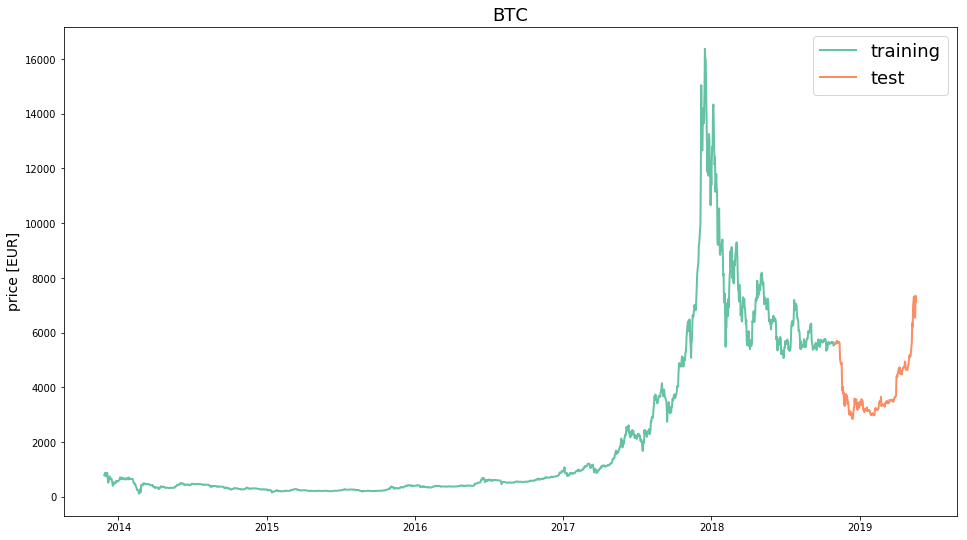

In [12]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

In [13]:
# BUILDING THE MODEL 
#For training the LSTM, the data was split into windows of 7 days 
# this number is arbitrary, we simply chose a week here
#and within each window we normalised the data to zero base, i.e. the first entry of each window is 0 
#and all other values represent the change with respect to the first value. 
#Hence, we are predicting price changes, rather than absolute price.

In [14]:

def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())



In [15]:

def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)



In [16]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


In [17]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [18]:
# BUILDING THE NEURONAL NETWORK
#I used a simple neural network with a single LSTM layer consisting of 20 neurons, 
#a dropout factor of 0.25, and a Dense layer with a single linear activation function.
#In addition, I used Mean Absolute Error (MAE) as loss function and the Adam optimiser.

#It has been trained trained the network for 50 epochs with a batch size of 4.
#Adam Optimizer is an adaptive learning rate optimization algorithm that’s been designed 
#specifically for training deep neural networks

In [19]:
def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [20]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'# Mean Absolute Error (MAE) is a loss function used for regression models
dropout = 0.25
optimizer = 'adam'


In [21]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [22]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1794/1794 [==============================] - 11s 6ms/step - loss: 0.0690
Epoch 2/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0462
Epoch 3/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0401
Epoch 4/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0382
Epoch 5/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0356
Epoch 6/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0344
Epoch 7/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0348
Epoch 8/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0339
Epoch 9/50
1794/1794 [==============================] - 9s 5ms/step - loss: 0.0323
Epoch 10/50
1794/

In [23]:
#PLOT PREDICTIONS

In [24]:

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()



In [25]:
mean_absolute_error(preds, y_test)

0.025272782171745316

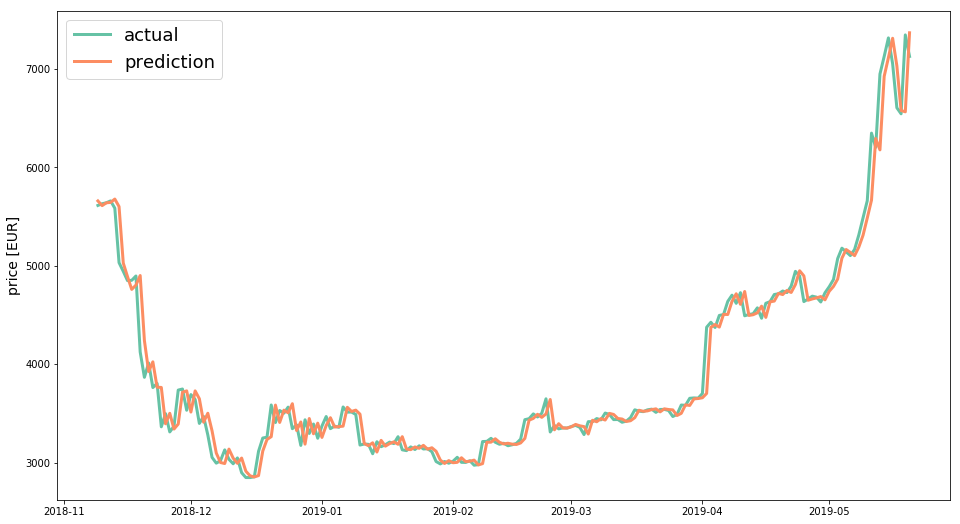

In [26]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [27]:
# Let’s take a closer look and zoom into the last 30 days of the plot.

# PROBLEM : for the prediction of a particular day, it is mostly using the value of the previous day.

#The prediction line doesn’t seem to be much more than a shifted version of the actual price.


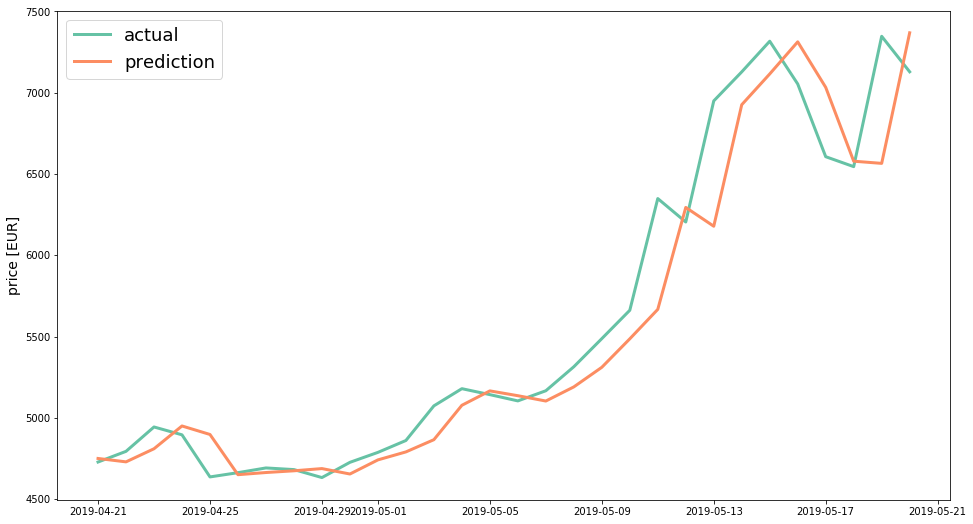

In [28]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

In [29]:
#We adjust the predictions and shift them by a day, then plot the " shifted" time series and we can observe an almost 
#perfect match between actual data and predictions, 
#indicating that the model is essentially learning the price at the previous day.

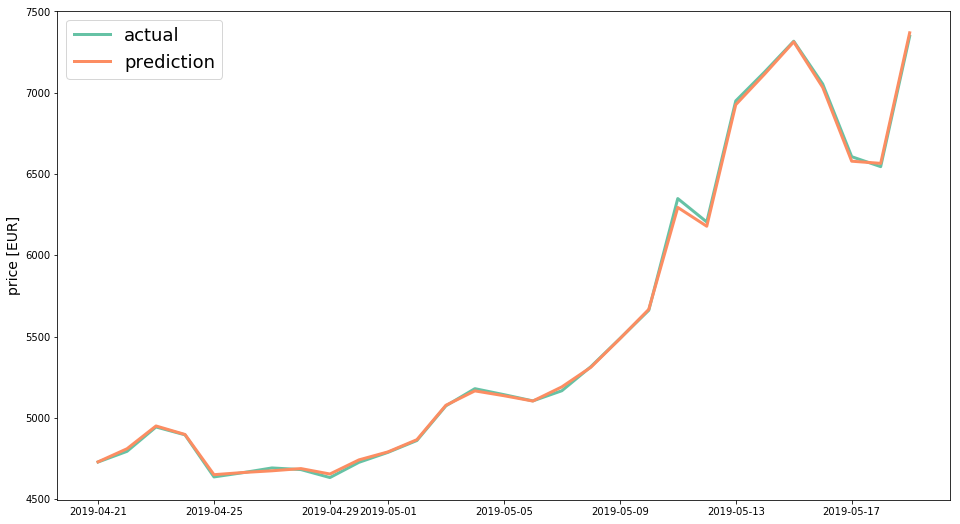

In [30]:


line_plot(targets[-n_points:][:-1], preds[-n_points:].shift(-1), 'actual', 'prediction', lw=3)



In [31]:
# COMPARE RETURNS

In [32]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

In [33]:
def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

In [34]:
#Looking at the actual and predicted returns, 
#both in their original form as well as with the 1-day-shift applied to them
#we obtain the same observation. ( second plot right)

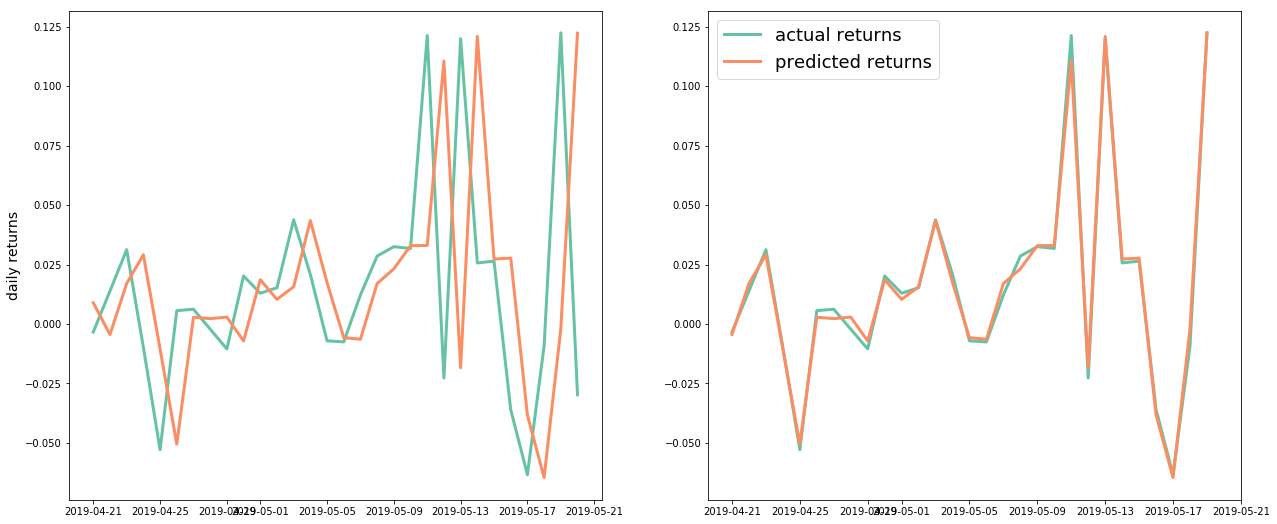

In [35]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)


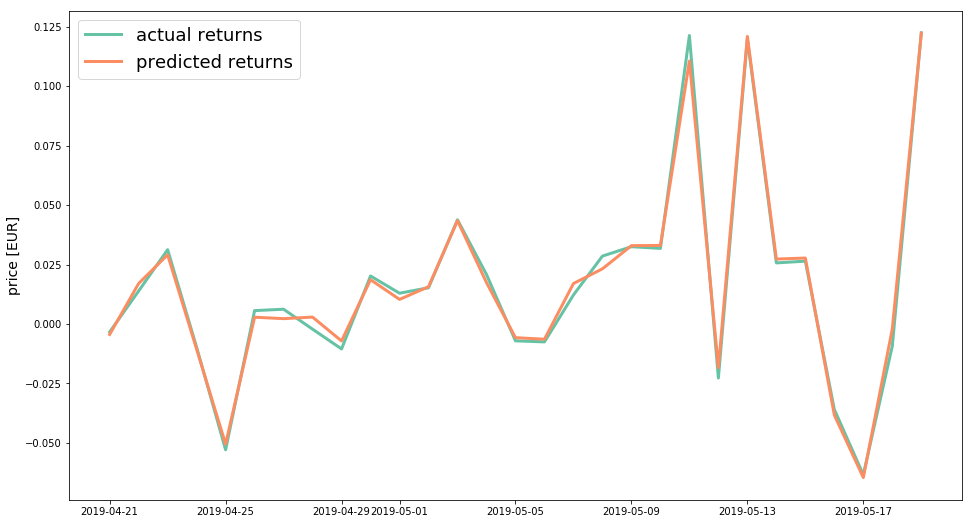

In [36]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)



In [37]:
#we compute the correlation between actual and predicted returns both for the original predictions 
#as well as for those adjusted by a day

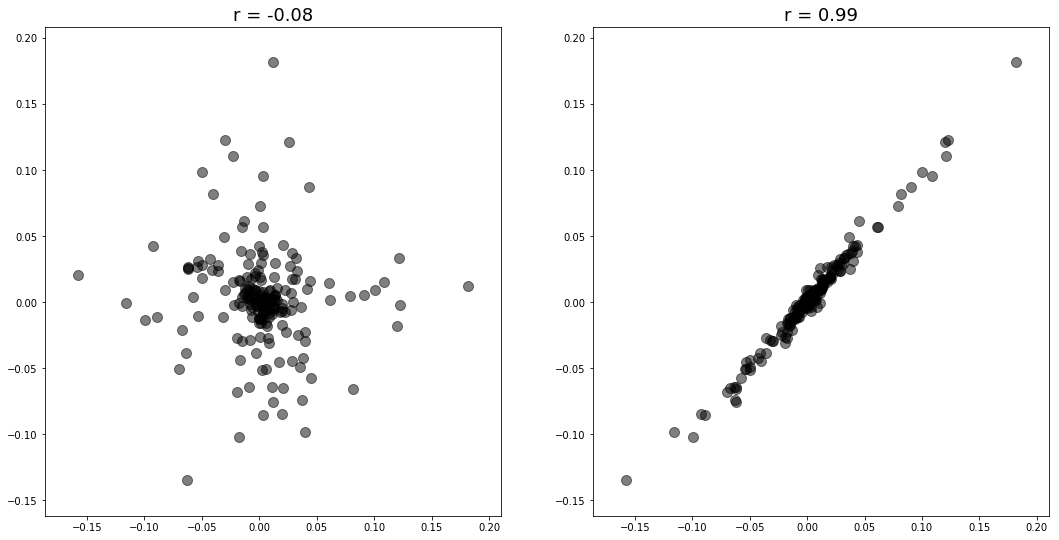

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);

In [39]:
#As you can see from the plots above, actual and predicted returns are uncorrelated. 
#Only after applying the 1-day-shift on the predictions 
#we obtain highly correlated returns that resemble the returns of the actual bitcoin data.